# Data Preparation

In [ ]:
!mkdir face-mask-detection
%cd face-mask-detection

/content/face-mask-detection


In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ahmadarbain","key":"948587cb4800a33478d94ffba4b14e1b"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d omkargurav/face-mask-dataset

100% 163M/163M [00:00<00:00, 171MB/s]
100% 163M/163M [00:00<00:00, 173MB/s]


In [ ]:
import tensorflow as tf
print(tf.__version__)

2.8.0


# Data Exploratory Processing

In [ ]:
!unzip face-mask-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: data/with_mask/with_mask_3297.jpg  
  inflating: data/with_mask/with_mask_3298.jpg  
  inflating: data/with_mask/with_mask_3299.jpg  
  inflating: data/with_mask/with_mask_33.jpg  
  inflating: data/with_mask/with_mask_330.jpg  
  inflating: data/with_mask/with_mask_3300.jpg  
  inflating: data/with_mask/with_mask_3301.jpg  
  inflating: data/with_mask/with_mask_3302.jpg  
  inflating: data/with_mask/with_mask_3303.jpg  
  inflating: data/with_mask/with_mask_3304.jpg  
  inflating: data/with_mask/with_mask_3305.jpg  
  inflating: data/with_mask/with_mask_3306.jpg  
  inflating: data/with_mask/with_mask_3307.jpg  
  inflating: data/with_mask/with_mask_3308.jpg  
  inflating: data/with_mask/with_mask_3309.jpg  
  inflating: data/with_mask/with_mask_331.jpg  
  inflating: data/with_mask/with_mask_3310.jpg  
  inflating: data/with_mask/with_mask_3311.jpg  
  inflating: data/with_mask/with_mask_3312.jpg  
  inflating: data/with

In [ ]:
import pathlib, glob, os 
import mlflow

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

In [ ]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
training_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/face-mask-detection/data',
    validation_split=0.2,
    subset= "training",
    seed=42,
    image_size= (img_height, img_width),
    batch_size=batch_size
)

Found 7553 files belonging to 2 classes.
Using 6043 files for training.


In [ ]:
testing_ds = tf.keras.preprocessing.image_dataset_from_directory(
'/content/face-mask-detection/data',
    validation_split=0.2,
    subset= "validation",
    seed=42,
    image_size= (img_height, img_width),
    batch_size=batch_size
)

Found 7553 files belonging to 2 classes.
Using 1510 files for validation.


In [ ]:
class_names = training_ds.class_names
class_names

['with_mask', 'without_mask']

In [ ]:
with_mask = pathlib.Path('/content/face-mask-detection/data/with_mask')
without_mask = pathlib.Path('/content/face-mask-detection/data/without_mask')

print(without_mask, without_mask)

/content/face-mask-detection/data/without_mask /content/face-mask-detection/data/without_mask


In [ ]:
with_mask = len(os.listdir(with_mask))
without_mask = len(os.listdir(without_mask))

print (with_mask, without_mask)

3725 3828


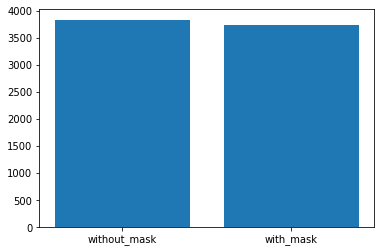

In [ ]:
import matplotlib.pyplot as plt

x=[]
y=[]
for foldername in os.listdir("/content/face-mask-detection/data"):
  x.append(foldername)
  count=0
  for filename in os.listdir("/content/face-mask-detection/data/"+foldername):
    count+=1
  y.append(count)
plt.bar(x,y)
plt.show()

without_mask


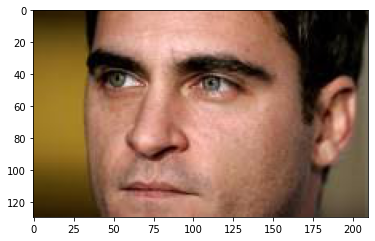

with_mask


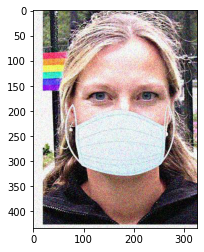

In [ ]:
import glob, random
import matplotlib.image as mpimg

for foldername in os.listdir("/content/face-mask-detection/data/"):
  file_path_type = ["/content/face-mask-detection/data/"+foldername+"/*.jpg"]
  print(foldername)
  images = glob.glob(random.choice(file_path_type))
  random_image = random.choice(images)
  img = mpimg.imread(random_image)
  imgplot = plt.imshow(img)
  plt.show()

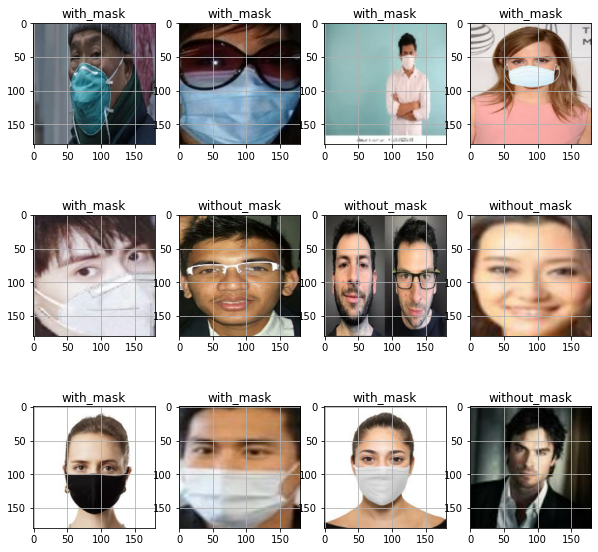

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in training_ds.take(1):
  for i in range(12):
    ax = plt.subplot(3, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.grid(True)

In [ ]:
for image_batch, labels_batch in training_ds :
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = training_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = testing_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
normalization_layer = layers.Rescaling(1./255)

In [ ]:
resize_and_rescale = tf.keras.Sequential([
                     layers.experimental.preprocessing.Resizing(img_height,img_width),
                     layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [ ]:
import numpy as np

normalized_ds = train_ds.map(lambda x, y: (resize_and_rescale(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.0 0.9771329


In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal_and_vertical",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
  ]
)

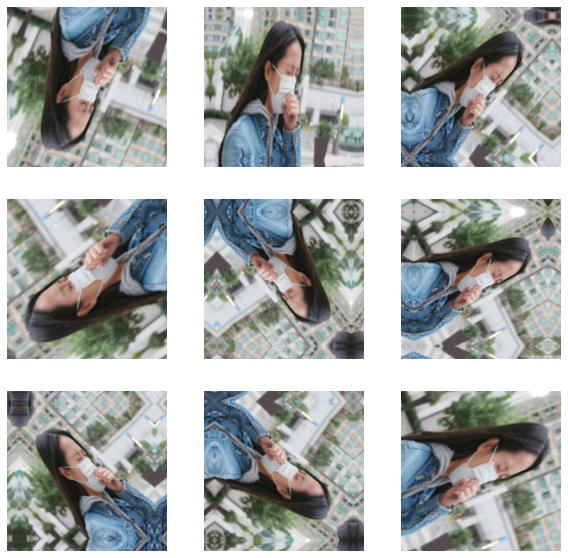

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
model = tf.keras.models.Sequential([
                           resize_and_rescale,
                           layers.Conv2D(64, kernel_size = (3,3), activation = 'relu', input_shape = (batch_size,img_height,img_width,3) ),
                           layers.MaxPooling2D((2,2)),
                           layers.Conv2D(128, kernel_size = (3,3), activation = 'relu'),
                           layers.MaxPooling2D((2,2)), 
                           layers.Conv2D(128, kernel_size = (3,3), activation = 'relu'),
                           layers.MaxPooling2D((2,2)),    
                           layers.Conv2D(128, (3, 3), activation='relu'),
                           layers.MaxPooling2D((2, 2)),
                           layers.Conv2D(128, (3, 3), activation='relu'),
                           layers.MaxPooling2D((2, 2)),    
                           layers.Flatten(),
                           layers.Dense(128, activation='relu'),
                           layers.Dense(23, activation='softmax')
])
model.build(input_shape = (batch_size,128,128,3))

In [ ]:
model.compile(
    optimizer='adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (32, 178, 178, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (32, 89, 89, 64)         0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 87, 87, 128)         73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 43, 43, 128)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 41, 41, 128)        

In [ ]:
epochs=20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  verbose=1
)

Epoch 1/20
189/189 [==============================] - 78s 353ms/step - loss: 0.6658 - accuracy: 0.6258 - val_loss: 0.3701 - val_accuracy: 0.8536
Epoch 2/20
189/189 [==============================] - 64s 336ms/step - loss: 0.3954 - accuracy: 0.8357 - val_loss: 0.3114 - val_accuracy: 0.8768
Epoch 3/20
189/189 [==============================] - 64s 336ms/step - loss: 0.3436 - accuracy: 0.8569 - val_loss: 0.2821 - val_accuracy: 0.8762
Epoch 4/20
189/189 [==============================] - 64s 340ms/step - loss: 0.3326 - accuracy: 0.8580 - val_loss: 0.2643 - val_accuracy: 0.8861
Epoch 5/20
189/189 [==============================] - 63s 335ms/step - loss: 0.3121 - accuracy: 0.8752 - val_loss: 0.2141 - val_accuracy: 0.9152
Epoch 6/20
189/189 [==============================] - 63s 335ms/step - loss: 0.2863 - accuracy: 0.8880 - val_loss: 0.2070 - val_accuracy: 0.9212
Epoch 7/20
189/189 [==============================] - 65s 342ms/step - loss: 0.2982 - accuracy: 0.8802 - val_loss: 0.2941 - val_ac

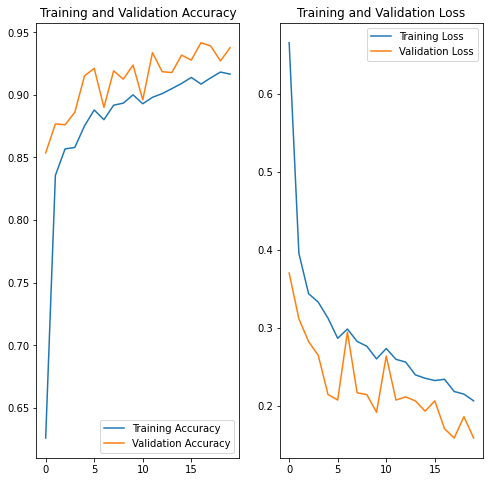

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

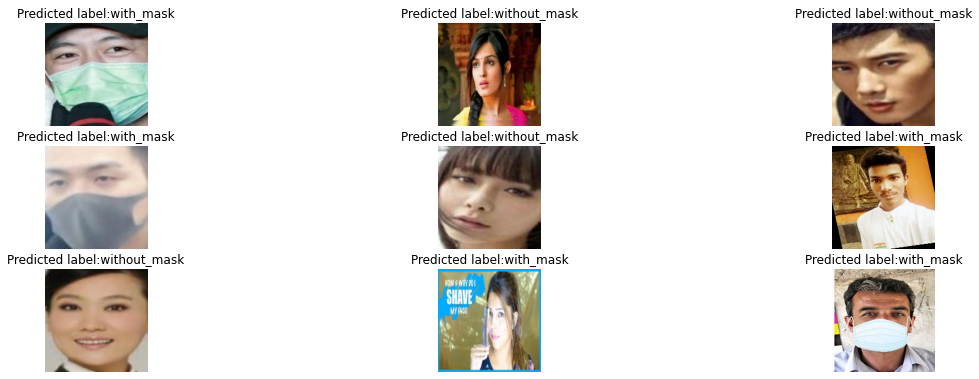

In [ ]:
plt.figure(figsize=(20, 20))
for images, labels in testing_ds.take(1):
    predictions = model.predict(images)
    predlabel = []
    
    for mem in predictions:
        predlabel.append(class_names[np.argmax(mem)])
    
    for i in range(9):
        ax = plt.subplot(9, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title('Predicted label:'+ predlabel[i])
        plt.axis('off')
        plt.grid(True)   
    

Saving man-5481987_960_720.jpg to man-5481987_960_720 (1).jpg
Using Mask


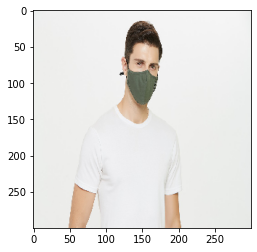

In [ ]:
from google.colab import files
from keras.preprocessing import image
import matplotlib.image as mpimg


uploaded = files.upload()

for fn in uploaded.keys():
  path = fn
  img = image.load_img(path, target_size=(300,300))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  
  images = np.vstack([x])
  prediction = model.predict(images, batch_size=10)

  scores = np.argmax(prediction[0])

  if scores == 0:
    print("Using Mask")
  else:
    print ("Without Mask")

In [ ]:
model.save('/model.h5')